<a href="https://colab.research.google.com/github/partha1189/machine_learning/blob/timeSeries/SimpleRNN_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

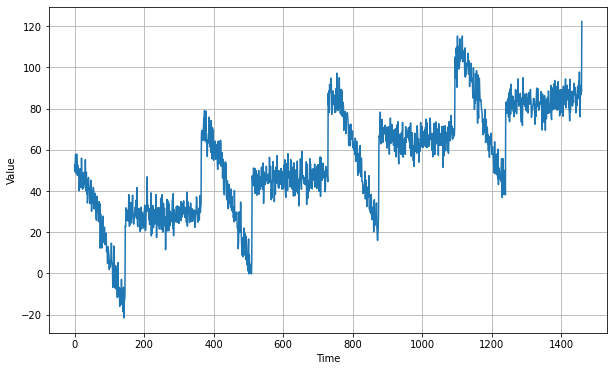

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# *SIMPLE RNN FORECASTING*


 **RNN Data shape(3D input)  
(batch_size, time_steps, output_dims)**

4, 30, 1

*   Keras assumes the first dimension as batch_size(it can be anything). So we dont mention batch size in input shape.
*   Next dimension is time_steps which we set as None,because RNN can take any number or time_steps.
*   Last Dimension is output_dim which is 1 incase of Univariate time series



Since our dataset was built to return 2D batches of windows**(batch_size, num_time_steps)** we have to expand the dims to add series dimensionality using a lambda layer.
*keras.layers.Lambda()*

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(series, window_size, batch_size=128)

In [6]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1), input_shape = [None]),
    keras.layers.SimpleRNN(100, return_sequences=True), 
    keras.layers.SimpleRNN(100), 
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [8]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

Using LR Scheduler for finding best Learning rate

In [9]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 0s 37ms/step - loss: 37.1824 - mae: 37.6803
Epoch 2/100
12/12 [==============================] - 0s 34ms/step - loss: 19.3383 - mae: 19.8326
Epoch 3/100
12/12 [==============================] - 0s 32ms/step - loss: 14.9266 - mae: 15.4175
Epoch 4/100
12/12 [==============================] - 0s 33ms/step - loss: 12.3683 - mae: 12.8544
Epoch 5/100
12/12 [==============================] - 0s 31ms/step - loss: 11.9289 - mae: 12.4146
Epoch 6/100
12/12 [==============================] - 0s 34ms/step - loss: 11.6009 - mae: 12.0868
Epoch 7/100
12/12 [==============================] - 0s 34ms/step - loss: 11.3785 - mae: 11.8650
Epoch 8/100
12/12 [==============================] - 0s 32ms/step - loss: 11.1918 - mae: 11.6761
Epoch 9/100
12/12 [==============================] - 0s 31ms/step - loss: 10.9481 - mae: 11.4352
Epoch 10/100
12/12 [==============================] - 0s 32ms/step - loss: 10.6583 - mae: 11.1458
Epoch 11/100
12/12 [=========

(1e-07, 0.0001, 0.0, 30.0)

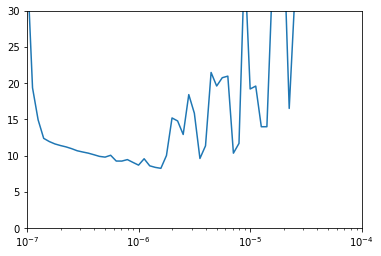

In [10]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1), input_shape = [None]),
    keras.layers.SimpleRNN(100, return_sequences=True), 
    keras.layers.SimpleRNN(100), 
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])


optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint", save_best_only=True)

model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 0s 30ms/step - loss: 57.3395 - mae: 57.8380WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 344ms/step - loss: 54.8857 - mae: 55.3844 - val_loss: 53.7732 - val_mae: 54.2732
Epoch 2/500
8/8 [==============================] - 3s 313ms/step - loss: 35.4596 - mae: 35.9565 - val_loss: 17.5200 - val_mae: 18.0162
Epoch 3/500
8/8 [==============================] - 0s 40ms/step - loss: 22.5446 - mae: 23.0386 - val_loss: 18.8168 - val_mae: 19.3137
Epoch 4

In [12]:
model = keras.models.load_model('my_checkpoint')

In [13]:
model.layers

In [14]:
rnn_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

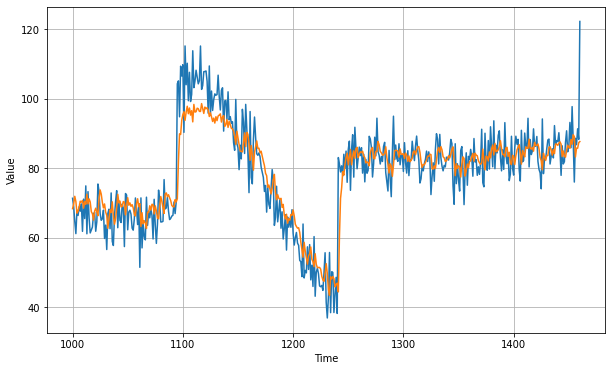

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.328214

# SEQUENCE TO SEQUENCE FORECASTING

In [18]:
def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [19]:
for X_batch, y_batch in seq2seq_window_dataset(tf.range(10), 3, batch_size=1):
  print('X:', X_batch.numpy())
  print('Y:', y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x : x * 200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 32ms/step - loss: 52.3618 - mae: 52.8614
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 25.4714 - mae: 25.9671
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 23.5029 - mae: 23.9972
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 21.1367 - mae: 21.6294
Epoch 5/100
8/8 [==============================] - 0s 33ms/step - loss: 19.4762 - mae: 19.9674
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 18.6742 - mae: 19.1647
Epoch 7/100
8/8 [==============================] - 0s 33ms/step - loss: 18.1698 - mae: 18.6587
Epoch 8/100
8/8 [==============================] - 0s 33ms/step - loss: 17.7679 - mae: 18.2568
Epoch 9/100
8/8 [==============================] - 0s 32ms/step - loss: 17.4389 - mae: 17.9280
Epoch 10/100
8/8 [==============================] - 0s 32ms/step - loss: 17.0989 - mae: 17.5875
Epoch 11/100
8/8 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

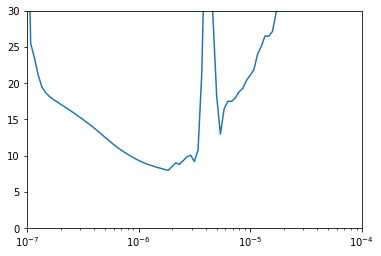

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 68ms/step - loss: 54.1428 - mae: 54.6413 - val_loss: 17.9209 - val_mae: 18.4158
Epoch 2/500
8/8 [==============================] - 0s 41ms/step - loss: 34.1721 - mae: 34.6694 - val_loss: 20.5482 - val_mae: 21.0441
Epoch 3/500
8/8 [==============================] - 0s 39ms/step - loss: 27.5074 - mae: 28.0027 - val_loss: 37.8712 - val_mae: 38.3707
Epoch 4/500
8/8 [==============================] - 0s 41ms/step - loss: 21.0646 - mae: 21.5578 - val_loss: 25.2685 - val_mae: 25.7675
Epoch 5/500
8/8 [==============================] - 0s 40ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3555 - val_mae: 15.8504
Epoch 6/500
8/8 [==============================] - 0s 42ms/step - loss: 15.0382 - mae: 15.5247 - val_loss: 9.4217 - val_mae: 9.9070
Epoch 7/500
8/8 [==============================] - 0s 43ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1617 - val_mae: 9.6474
Epoch 8/500
8/8 [==============================] - 0s 41ms/step - 

In [23]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

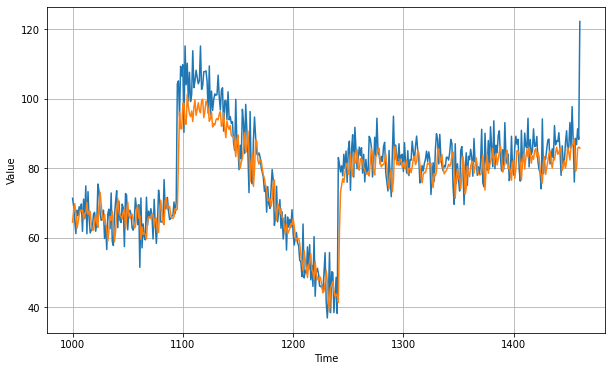

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [25]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.4588637